In [0]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score,mean_absolute_error

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.layers import concatenate,Input, Dense ,Dropout
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


TensorFlow 2.x selected.


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv("gdrive/My Drive/forecasting/base_promo_trainset.csv")
# df_test=pd.read_csv("gdrive/My Drive/forecasting/base_promo_testset.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Metrics
#RMSE
def rmse(y_true,y_pred):
  return r2_score(y_true, y_pred)
def MAE(y_true,y_pred):
  return mean_absolute_error
def MAPE(y_true,y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

In [0]:
df_test["MAG"].unique()

array(['E01', 'E15', 'W91', 'M41', 'I26', 'I36'], dtype=object)

In [0]:
df_train.drop(["account_id","date_id"],inplace=True,axis=1)
df_test.drop(["account_id","date_id"],inplace=True,axis=1)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
mag_replace_dict=dict(zip(list((df_train['MAG'].unique())), list(range(len(df_train['MAG'].unique())))))
df_train["MAG"]=df_train["MAG"].replace(mag_replace_dict)
df_test["MAG"]=df_test["MAG"].replace(mag_replace_dict)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
def preprocess_data(dataset):

  product_id=tf.cast(dataset['product_id'],dtype=tf.float32)
  MAG=tf.cast(dataset['MAG'],dtype=tf.float32)
  AG=tf.cast(dataset['AG'],dtype=tf.float32)
  promo_flag=tf.cast(dataset['promo_flag'],dtype=tf.float32)
  promo_discount_perc=tf.cast(dataset['promo_discount_perc'],dtype=tf.float32)
  base_demand=tf.cast(dataset['base_demand'],dtype=tf.float32)
  ordered_units=tf.cast(dataset['ordered_units'],dtype=tf.float32)
  num_dat=tf.stack([promo_flag,promo_discount_perc,base_demand],axis=1)
  # X=MAG,AG,product_id,promo_flag,promo_discount_perc,base_demand

  X=MAG,AG,product_id,num_dat
  y=ordered_units 
  # X=MAG,AG,product_id,promo_flag,promo_discount_perc,base_demand
  return X,y

In [0]:
def test_preprocess_data(dataset):

  product_id=tf.cast(dataset['product_id'],dtype=tf.float32)
  MAG=tf.cast(dataset['MAG'],dtype=tf.float32)
  AG=tf.cast(dataset['AG'],dtype=tf.float32)
  promo_flag=tf.cast(dataset['promo_flag'],dtype=tf.float32)
  promo_discount_perc=tf.cast(dataset['promo_discount_perc'],dtype=tf.float32)
  base_demand=tf.cast(dataset['base_demand'],dtype=tf.float32)
  ordered_units=tf.cast(dataset['ordered_units'],dtype=tf.float32)
  num_dat=tf.stack([promo_flag,promo_discount_perc,base_demand],axis=1)
  # X=MAG,AG,product_id,promo_flag,promo_discount_perc,base_demand

  X=MAG,AG,product_id,num_dat
  y=ordered_units 
  # X=MAG,AG,product_id,promo_flag,promo_discount_perc,base_demand
  return MAG,AG,product_id,num_dat

In [0]:
#Preparing dataset
dataset= tf.data.Dataset.from_tensor_slices(dict(df_train))
dataset=dataset.batch(8, drop_remainder=True)
dataset=dataset.map(preprocess_data)

In [0]:
#Preparing dataset
test_dataset= tf.data.Dataset.from_tensor_slices(dict(df_test))
test_dataset=test_dataset.batch(8, drop_remainder=True)
test_dataset=test_dataset.map(preprocess_data)

In [0]:
callbacks=[EarlyStopping(monitor='val_loss', patience=5)]

In [0]:
mag=Input(shape=(1,),name='MAG')
mag_dense = Dense(5, activation='relu',name='MAG_dense')(mag)

ag=Input(shape=(1,),name='AG')
ag_dense = Dense(7, activation='relu',name='AG_dense')(ag)

product_id=Input(shape=(1,),name='product_id')
product_id_dense = Dense(20, activation='relu',name='product_id_dense')(product_id)

num_dat=Input(shape=(3,),name='num_dat')
num_dat_dense = Dense(20, activation='relu',name='num_dat_dense')(num_dat)


concat_layer = concatenate([mag_dense,ag_dense,product_id_dense,num_dat_dense])
# concat_layer = concatenate([mag_dense,ag_dense])

dense_1 = Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.0001), name='dense_1')(concat_layer)
drop_x_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.0001), name='dense_2')(drop_x_1)
drop_x_2 = Dropout(0.2)(dense_1)
output = Dense(1, activation='linear',kernel_regularizer=regularizers.l2(0.0001), name='output')(drop_x_2)




input_var=[mag,ag,product_id,num_dat]

model = Model(inputs=input_var,outputs=output)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MAG (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
AG (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
product_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
num_dat (InputLayer)            [(None, 3)]          0                                            
______________________________________________________________________________________________

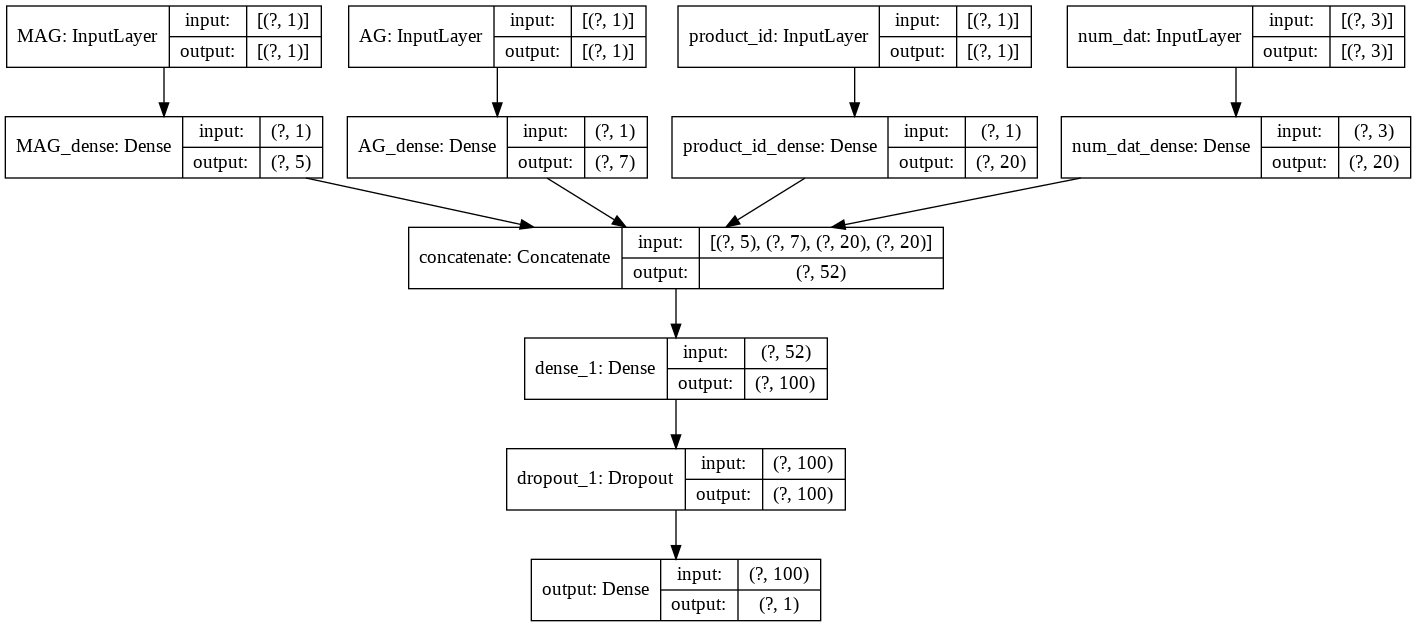

In [0]:
plot_model(model, 'my_first_model.png',show_shapes=True)

In [0]:
cat_cols=['product_id','MAG','AG']
num_cols=['promo_discount_perc','promo_flag','base_demand']

In [0]:

# Fit model
model.fit(dataset,epochs=30,validation_data=test_dataset)


Train for 1537 steps, validate for 381 steps
Epoch 1/30
1537/1537 [==============================] - 6s 4ms/step - loss: 351199.8655 - mse: 351199.5625 - mape: 58616930304.0000 - val_loss: 347977.5838 - val_mse: 347977.5625 - val_mape: 9580850176.0000
Epoch 2/30
1537/1537 [==============================] - 5s 3ms/step - loss: 288795.6478 - mse: 288795.5938 - mape: 29554378752.0000 - val_loss: 334034.9736 - val_mse: 334034.7500 - val_mape: 5192469504.0000
Epoch 3/30
1537/1537 [==============================] - 5s 3ms/step - loss: 279926.5812 - mse: 279926.7812 - mape: 19062626304.0000 - val_loss: 331051.6201 - val_mse: 331051.7500 - val_mape: 9974709248.0000
Epoch 4/30
1537/1537 [==============================] - 5s 3ms/step - loss: 272938.6332 - mse: 272938.7500 - mape: 14877221888.0000 - val_loss: 332690.7965 - val_mse: 332690.7812 - val_mape: 6596320768.0000
Epoch 5/30
1537/1537 [==============================] - 5s 3ms/step - loss: 273093.1612 - mse: 273093.1562 - mape: 10826417152.

In [0]:
#Train r2_score
y_train_pred=model.predict(dataset)
y_train=df_train['ordered_units'][:len(y_train_pred)]
y_train_pred[y_train_pred<0]=0
print("Train r2_score",r2_score(y_train,y_train_pred))

Train r2_score 0.6901536518648532


In [0]:
#Test r2_score
y_test_pred=model.predict(test_dataset)
y_test=df_test['ordered_units'][:len(y_test_pred)]
y_test_pred[y_test_pred<0]=0
r2_score(y_test,y_test_pred)

0.6678474736462908